In [101]:
import pandas as pd
import clickhouse_connect
import swifter
import hashlib
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu
import matplotlib.pyplot as plt
import orbit
from orbit.models import DLT
from orbit.diagnostics.plot import plot_predicted_components
from orbit.eda import eda_plot
from orbit.diagnostics.plot import plot_predicted_data
from orbit.diagnostics.backtest import BackTester
from orbit.utils.params_tuning import grid_search_orbit
import arviz as az

In [2]:
client = clickhouse_connect.get_client(
    host='clickhouse.lab.karpov.courses',  # без https://
    port=443,                              # т.к. https
    username='student',
    password='dpo_python_2020',
    database='simulator',
    secure=True                            # включаем TLS
)

In [52]:
q = '''
SELECT
    toStartOfHour(time) AS hour_time,
    sum(action='like') / sum(action='view') AS CTR
FROM simulator_20250820.feed_actions
WHERE time >= toDateTime('2025-07-26 00:00:00')
  AND time <  toDateTime('2025-08-23 00:00:00')
GROUP BY hour_time
ORDER BY hour_time
'''

In [53]:
#q = """
#SELECT exp_group, 
#    user_id,
#    sum(action = 'like') as likes,
#    sum(action = 'view') as views,
#    likes/views as ctr
#FROM simulator_20250820.feed_actions 
#WHERE toDate(time) >= '2025-08-16' and toDate(time) <= '2025-08-22' 
#    and exp_group in (2,3)
#GROUP BY exp_group, user_id
#"""

In [54]:
# Вытащили пользователей
activity = client.query_df(q)

In [55]:
activity['hour_time'] = pd.to_datetime(activity['hour_time']).dt.tz_localize(None)

In [56]:
activity

,hour_time,CTR
0,2025-07-26 00:00:00,0.220720
1,2025-07-26 01:00:00,0.217071
2,2025-07-26 02:00:00,0.221075
3,2025-07-26 03:00:00,0.216127
4,2025-07-26 04:00:00,0.217627
...,...,...
667,2025-08-22 19:00:00,0.209487
668,2025-08-22 20:00:00,0.209446
669,2025-08-22 21:00:00,0.206052
670,2025-08-22 22:00:00,0.205755


In [57]:
sns.set(rc={'figure.figsize':(16,6)}, style='whitegrid')

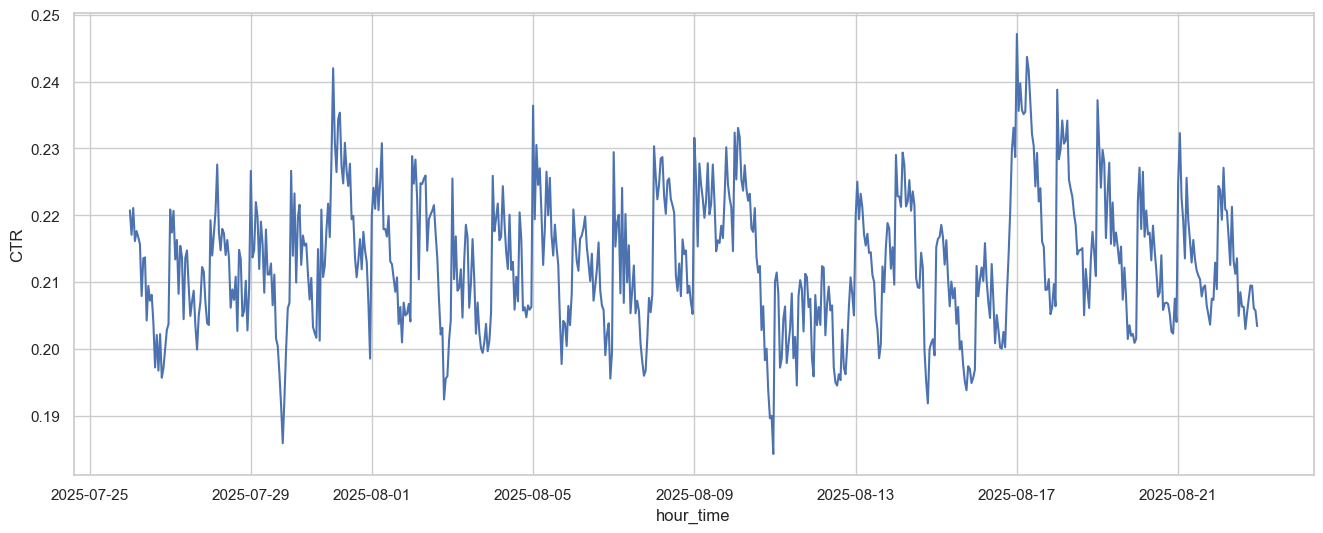

In [58]:
sns.lineplot(x='hour_time', y='CTR', data=activity);

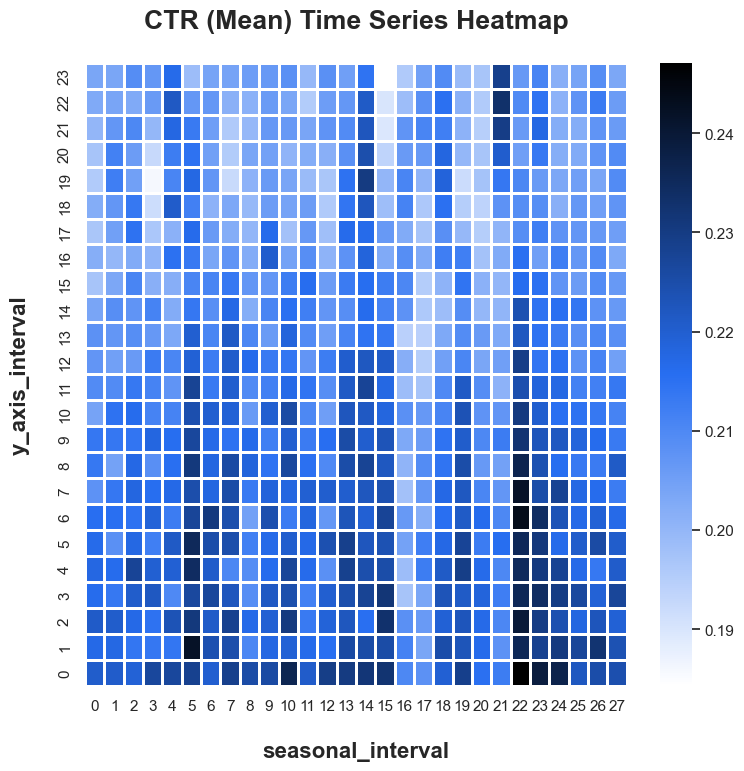

In [59]:
_ = eda_plot.ts_heatmap(df=activity, date_col = 'hour_time', value_col='CTR', seasonal_interval=24, normalization=False)

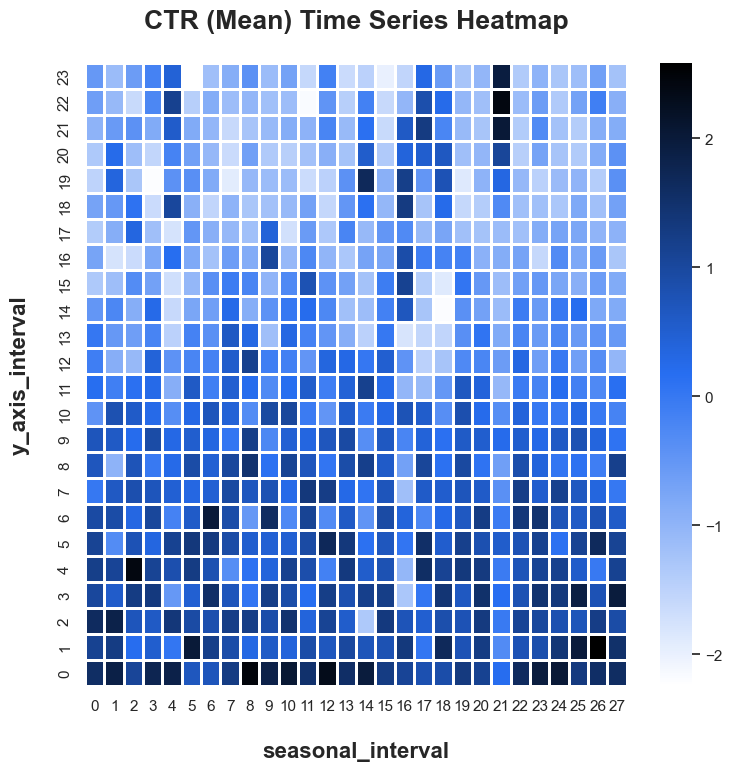

In [60]:
_ = eda_plot.ts_heatmap(df=activity, date_col = 'hour_time', value_col='CTR', seasonal_interval=24, normalization=True)

In [61]:
dlt = DLT(
    response_col='CTR',
    date_col='hour_time',
    seasonality=24,        # дневная сезонность для часов
    estimator='stan-map',
    n_bootstrap_draws=1000
)

2025-09-20 11:58:53 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.


In [62]:
dlt.fit(activity)

In [63]:
future_df = dlt.make_future_df(periods=24*7)
future_df.head()

,hour_time
0,2025-08-23 00:00:00
1,2025-08-23 01:00:00
2,2025-08-23 02:00:00
3,2025-08-23 03:00:00
4,2025-08-23 04:00:00


In [64]:
predicted_df = dlt.predict(df=future_df)
predicted_df.head()

,hour_time,prediction_5,prediction,prediction_95
0,2025-08-23 00:00:00,0.216104,0.224031,0.232103
1,2025-08-23 01:00:00,0.210581,0.219334,0.227604
2,2025-08-23 02:00:00,0.209800,0.219283,0.229161
3,2025-08-23 03:00:00,0.208681,0.219045,0.229057
4,2025-08-23 04:00:00,0.207450,0.218279,0.229010


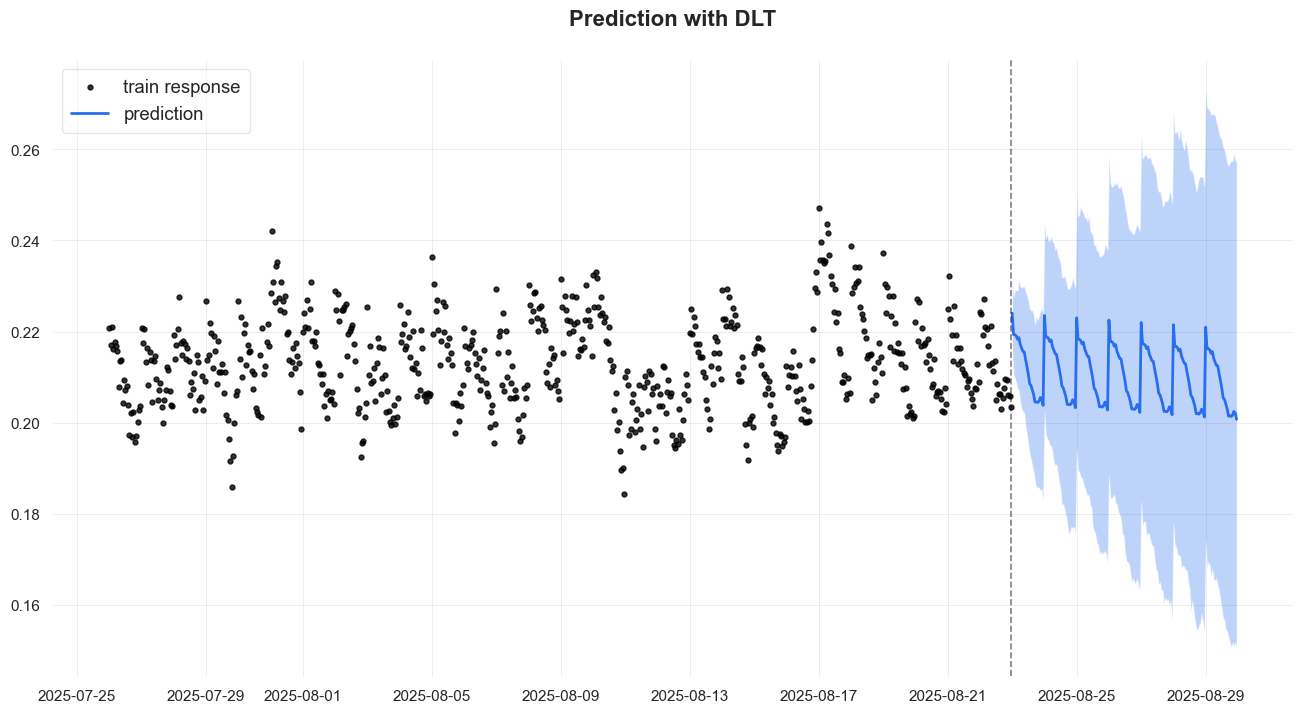

In [67]:
_ = plot_predicted_data(activity, predicted_df, 'hour_time', 'CTR', title='Prediction with DLT')

In [68]:
predicted_df = dlt.predict(df=future_df, decompose=True)
predicted_df.head()

,hour_time,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
0,2025-08-23 00:00:00,0.216449,0.224031,0.232005,0.204428,0.212010,0.219984,0.012021,0.012021,0.012021,0.0,0.0,0.0
1,2025-08-23 01:00:00,0.211245,0.219334,0.228312,0.203899,0.211989,0.220967,0.007345,0.007345,0.007345,0.0,0.0,0.0
2,2025-08-23 02:00:00,0.209987,0.219283,0.229234,0.202671,0.211967,0.221918,0.007315,0.007315,0.007315,0.0,0.0,0.0
3,2025-08-23 03:00:00,0.208757,0.219045,0.229646,0.201658,0.211946,0.222547,0.007099,0.007099,0.007099,0.0,0.0,0.0
4,2025-08-23 04:00:00,0.207050,0.218279,0.229826,0.200695,0.211924,0.223471,0.006355,0.006355,0.006355,0.0,0.0,0.0


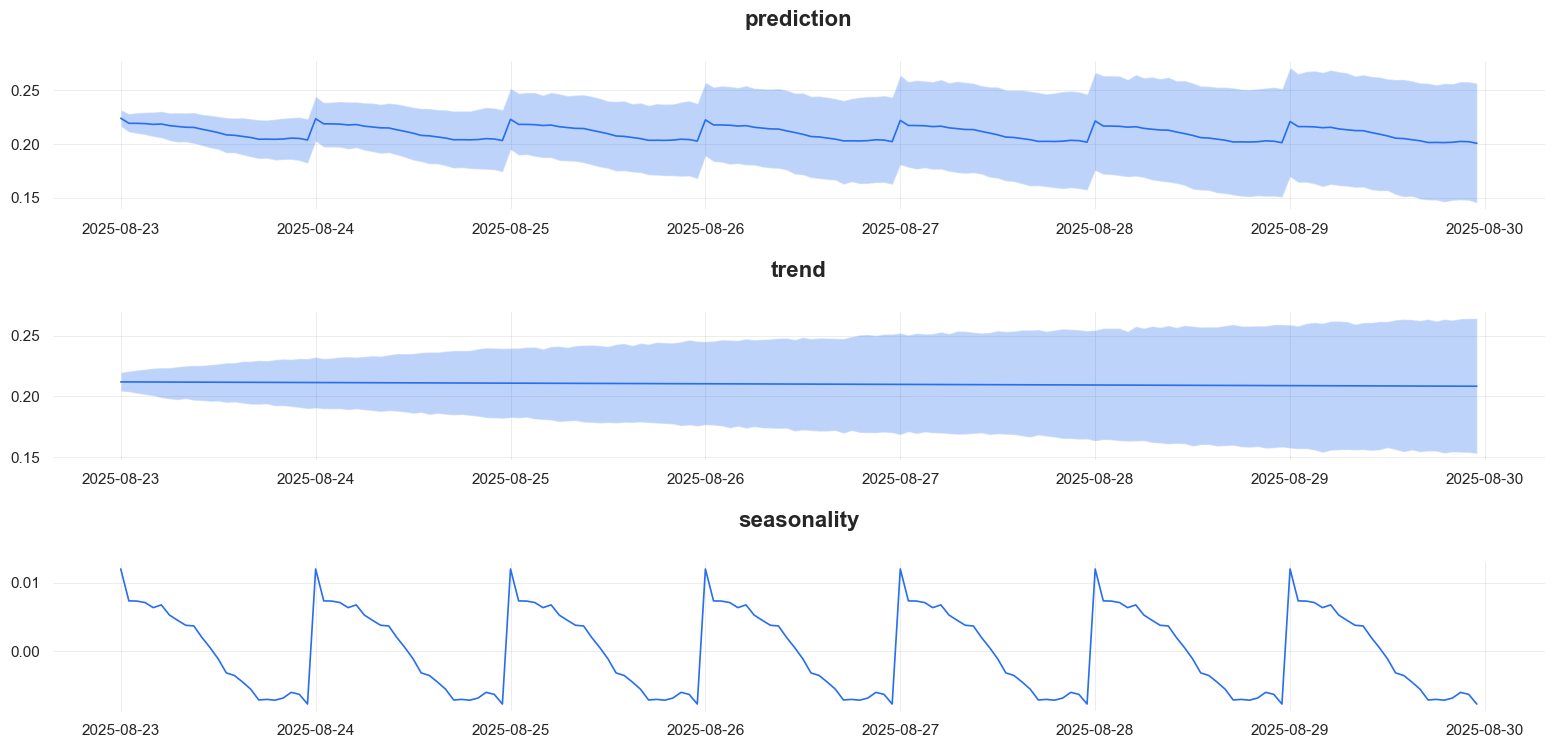

In [70]:
_ = plot_predicted_components(predicted_df, 'hour_time', plot_components=['prediction', 'trend','seasonality'])

In [71]:
dlt_mcmc = DLT(
    response_col='CTR',
    date_col='hour_time',
    seasonality=24,        # дневная сезонность для часов
    estimator='stan-mcmc',
    num_warmup=2000,
    num_sample=1000
)

In [72]:
dlt_mcmc.fit(activity)

2025-09-20 12:39:06 - orbit - INFO - Sampling (CmdStanPy) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.
INFO:orbit:Sampling (CmdStanPy) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [73]:
future_df = dlt_mcmc.make_future_df(periods=24*7)
future_df.head()

,hour_time
0,2025-08-23 00:00:00
1,2025-08-23 01:00:00
2,2025-08-23 02:00:00
3,2025-08-23 03:00:00
4,2025-08-23 04:00:00


In [74]:
predicted_df = dlt_mcmc.predict(df=future_df)
predicted_df.head()

,hour_time,prediction_5,prediction,prediction_95
0,2025-08-23 00:00:00,0.216182,0.223766,0.232658
1,2025-08-23 01:00:00,0.210557,0.219467,0.228842
2,2025-08-23 02:00:00,0.210117,0.218978,0.229445
3,2025-08-23 03:00:00,0.207911,0.219069,0.229809
4,2025-08-23 04:00:00,0.206632,0.218237,0.230003


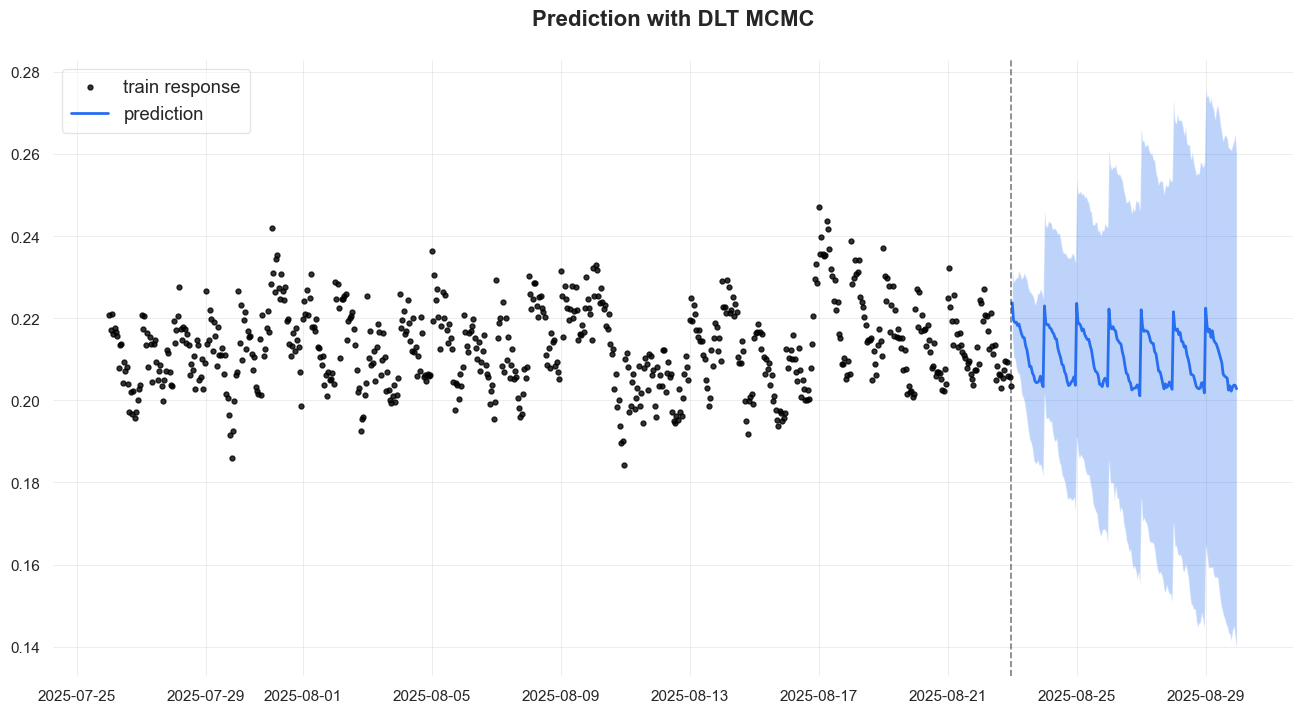

In [75]:
_ = plot_predicted_data(activity, predicted_df, 'hour_time', 'CTR', title='Prediction with DLT MCMC')

In [76]:
predicted_df = dlt_mcmc.predict(df=future_df, decompose=True)
predicted_df.head()

,hour_time,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
0,2025-08-23 00:00:00,0.215335,0.224062,0.232208,0.203383,0.211734,0.219653,0.010844,0.012245,0.013623,0.0,0.0,0.0
1,2025-08-23 01:00:00,0.209729,0.219225,0.228727,0.202209,0.211674,0.221092,0.006109,0.007569,0.008935,0.0,0.0,0.0
2,2025-08-23 02:00:00,0.208706,0.218971,0.229671,0.201593,0.211577,0.222559,0.005967,0.007227,0.008552,0.0,0.0,0.0
3,2025-08-23 03:00:00,0.208580,0.219506,0.230058,0.201381,0.212258,0.223045,0.005874,0.007201,0.008389,0.0,0.0,0.0
4,2025-08-23 04:00:00,0.206042,0.217787,0.229251,0.199977,0.211751,0.222778,0.004872,0.006252,0.007590,0.0,0.0,0.0


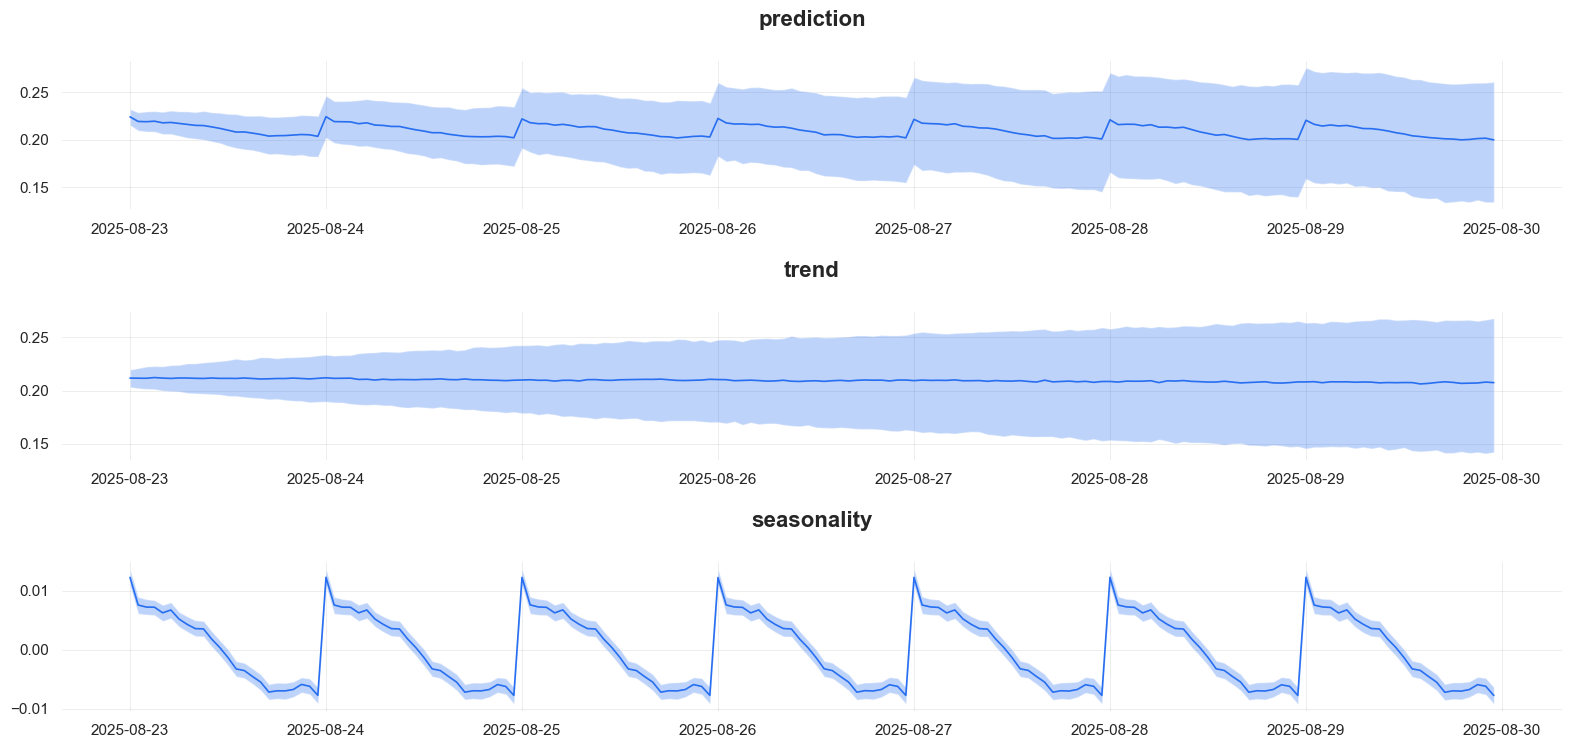

In [77]:
_ = plot_predicted_components(predicted_df, 'hour_time', plot_components=['prediction', 'trend','seasonality'])

In [86]:
bt_exp = BackTester(
    model=dlt,
    df=activity,
    min_train_len=24,
    forecast_len=24,
    window_type='expanding'
)

In [87]:
bt_exp.fit_predict()

In [88]:
bt_exp.score()

,metric_name,metric_values,is_training_metric
0,smape,0.030077,False
1,wmape,0.029868,False
2,mape,0.029996,False
3,mse,0.000075,False
4,mae,0.006368,False
5,rmsse,1.267412,False


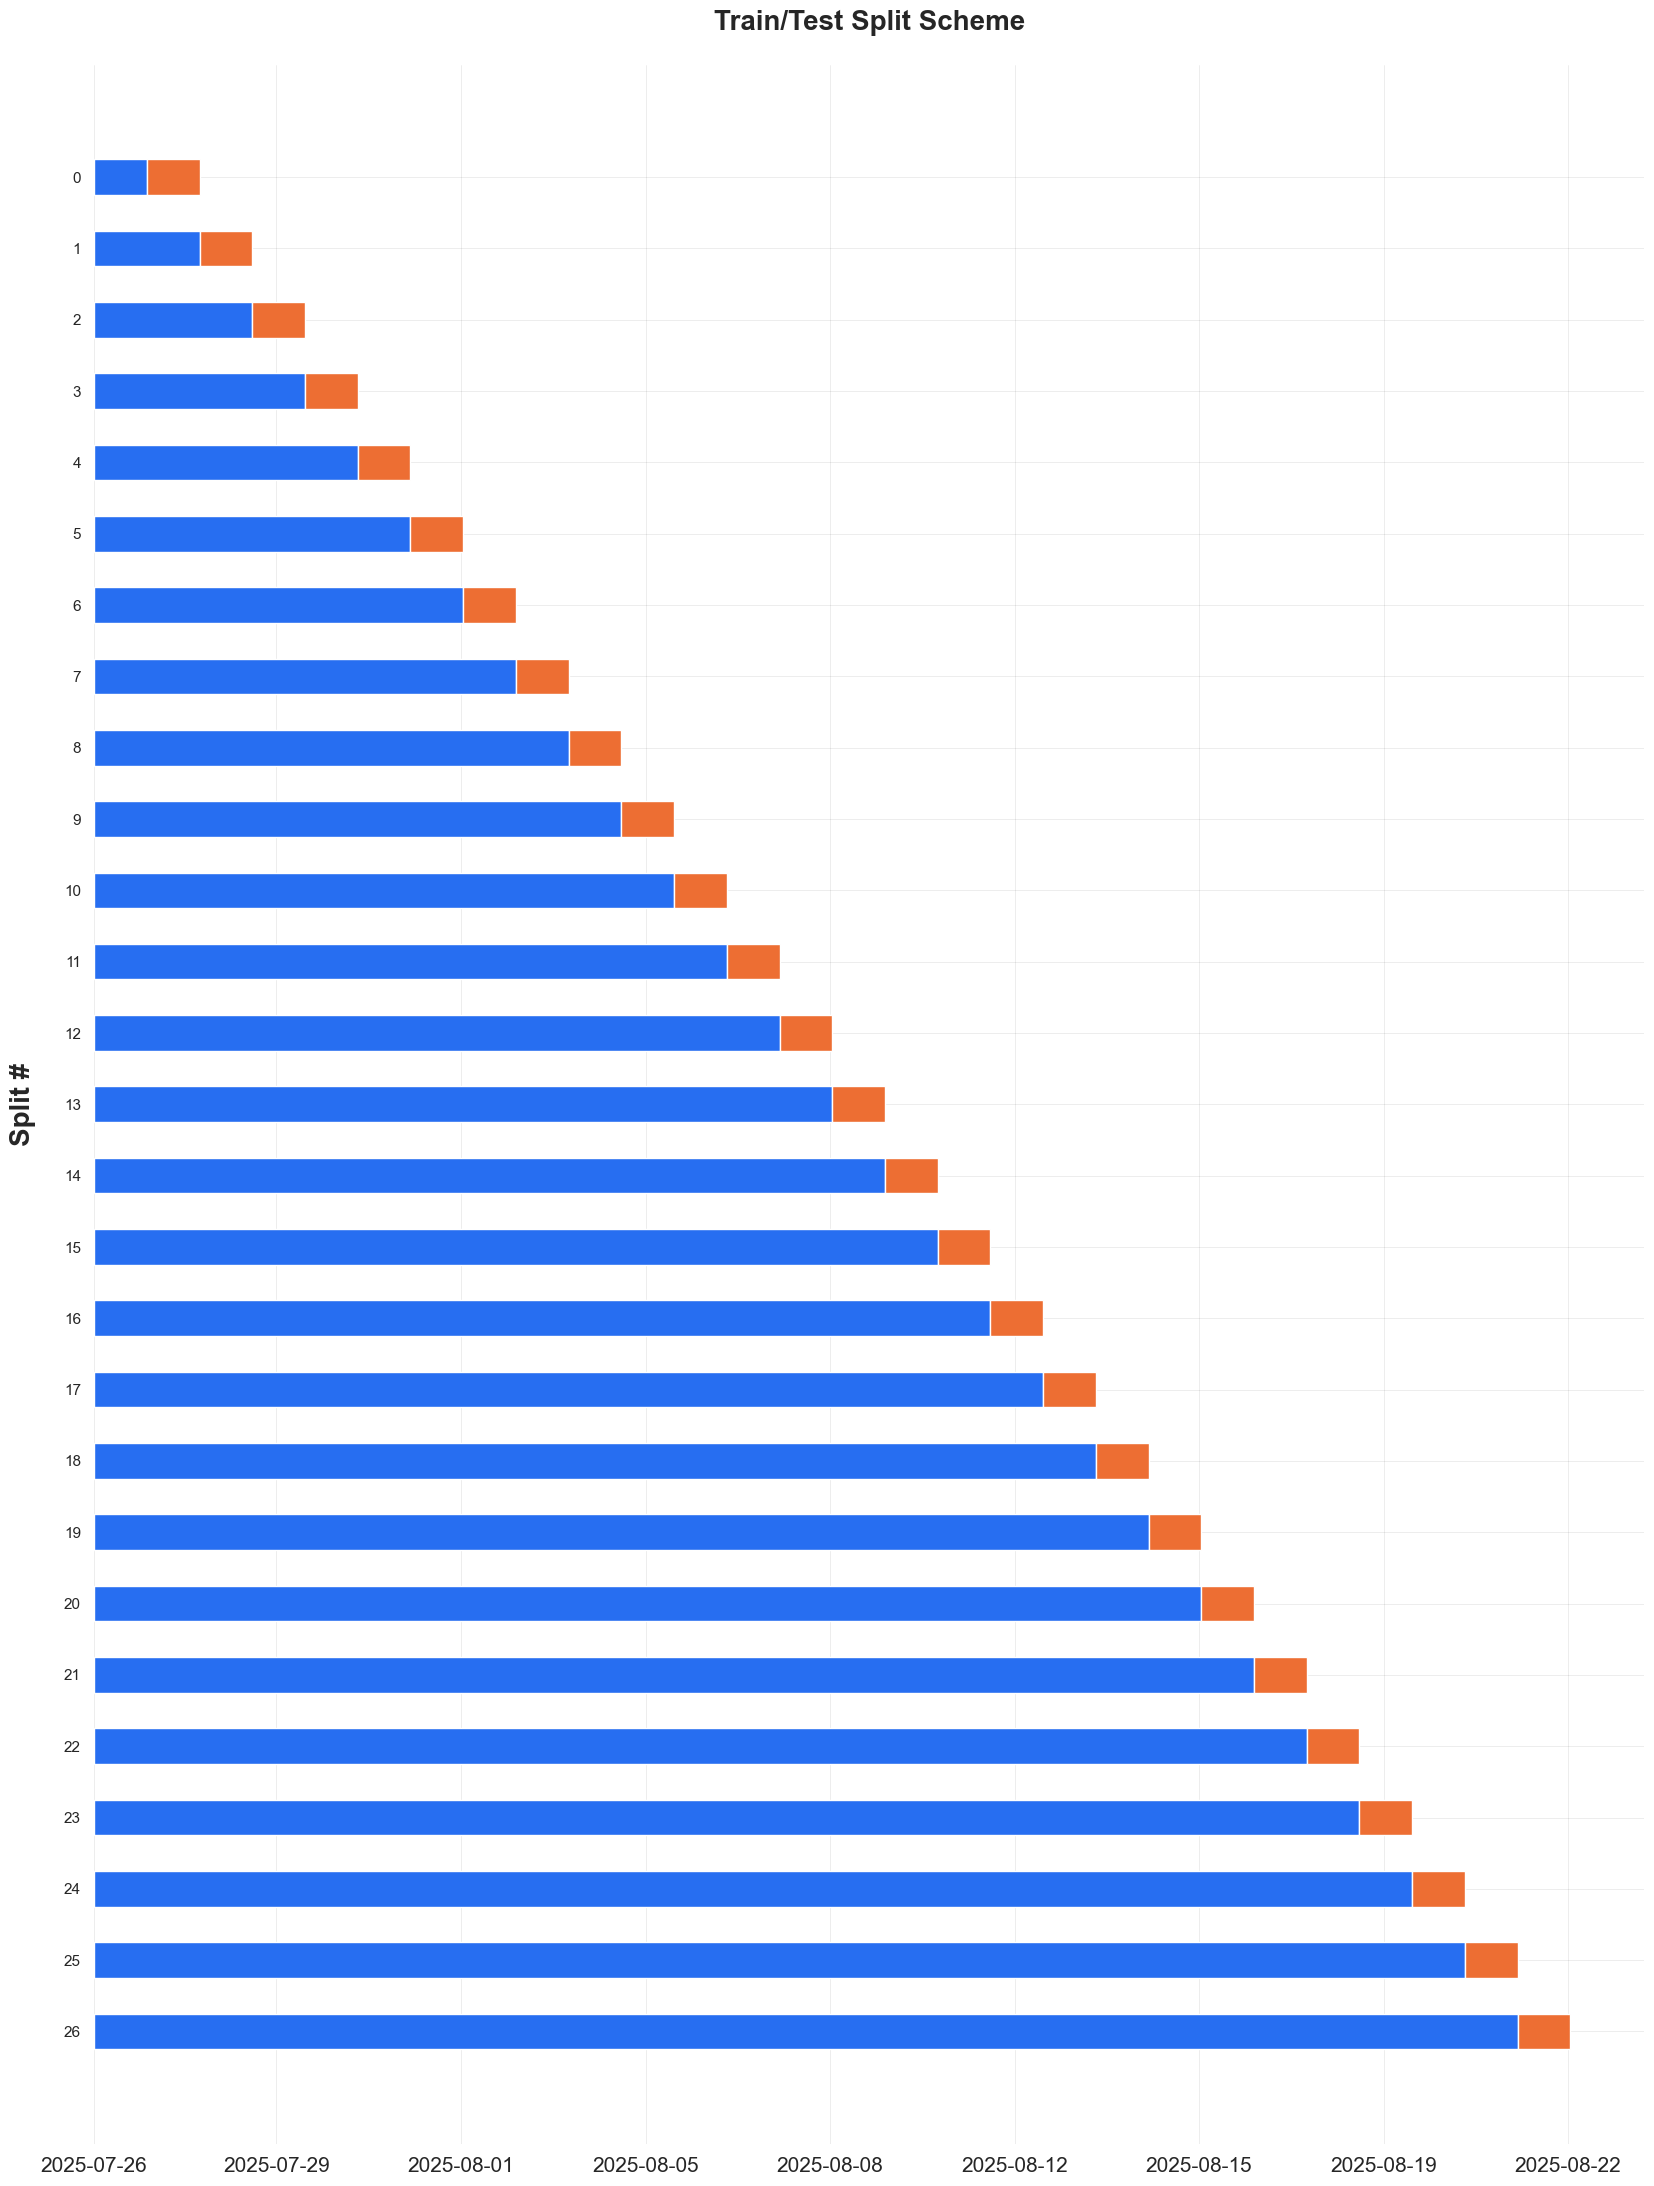

In [81]:
bt_exp.plot_scheme()

In [89]:
bt_exp = BackTester(
    model=dlt,
    df=activity,
    min_train_len=24,
    forecast_len=24,
    window_type='rolling'
)

In [90]:
bt_exp.fit_predict()

In [91]:
bt_exp.score()

,metric_name,metric_values,is_training_metric
0,smape,0.041232,False
1,wmape,0.040813,False
2,mape,0.040691,False
3,mse,0.000131,False
4,mae,0.008702,False
5,rmsse,1.670603,False


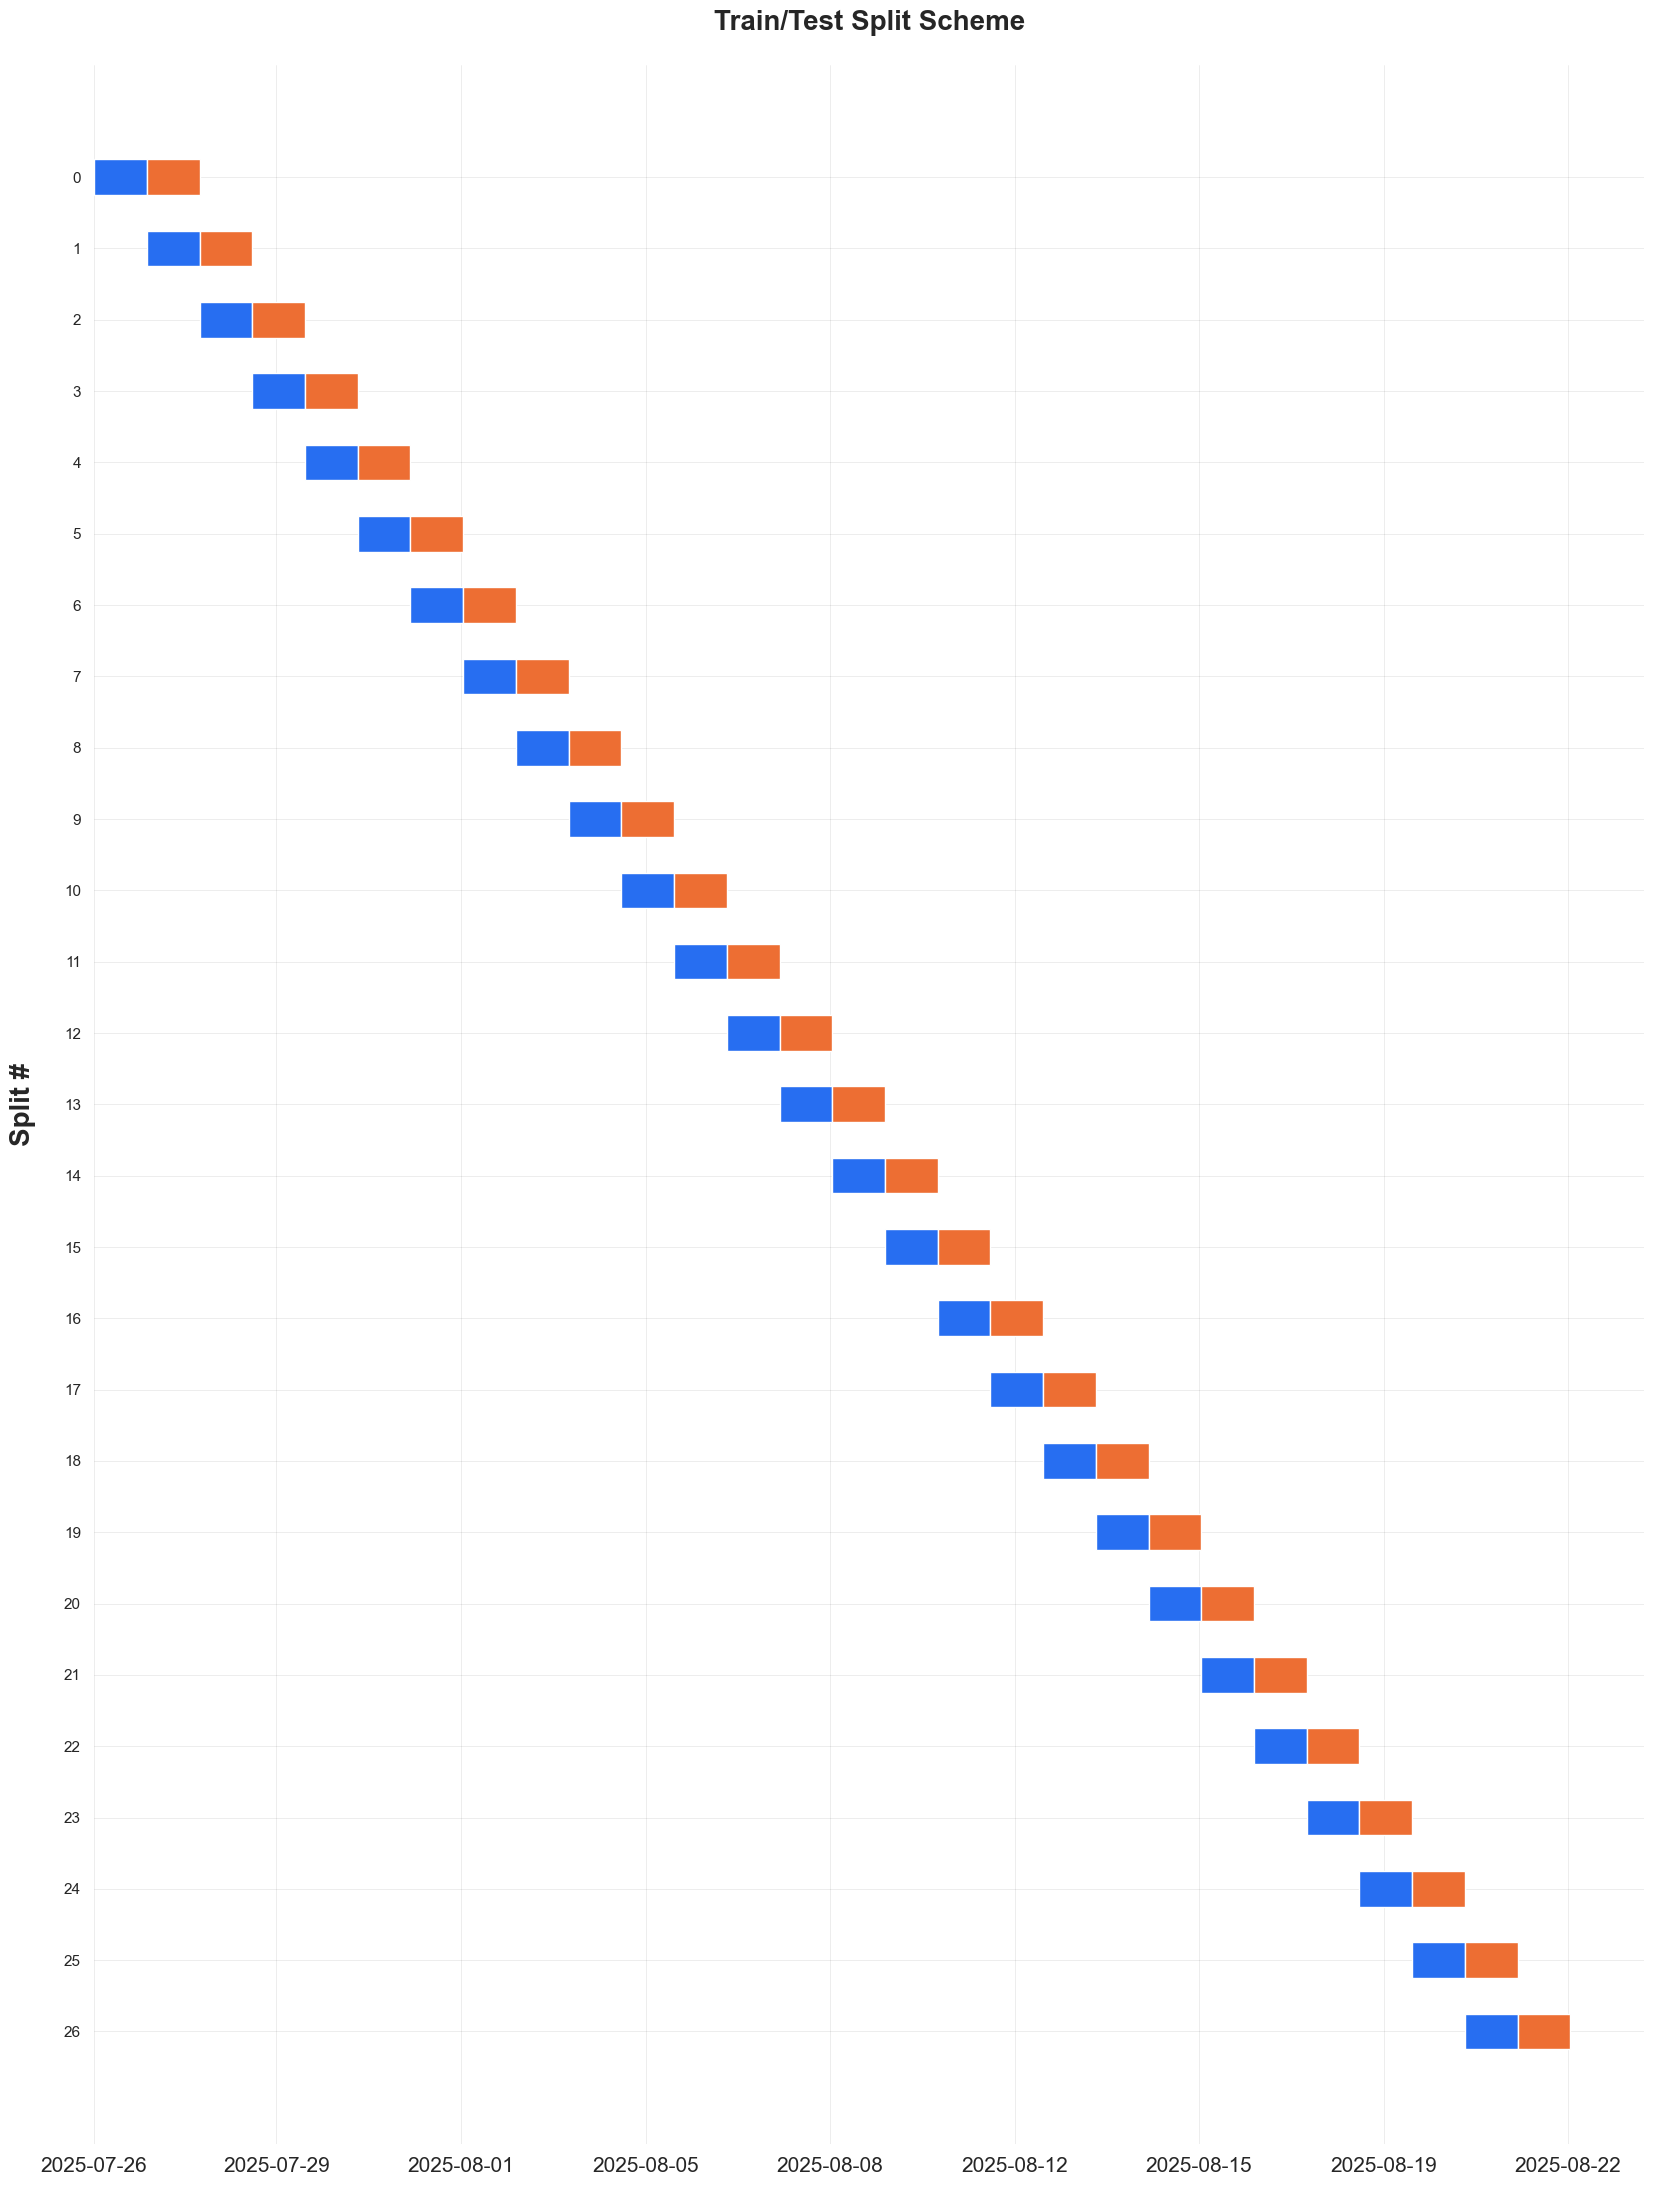

In [83]:
bt_exp.plot_scheme()

In [93]:
best_params, tuned_df = grid_search_orbit(
    param_grid={'damped_factor': np.arange(0.1,1.0,0.1)},
    model=dlt,
    df=activity,
    min_train_len=24*7,
    incremental_len=24,
    forecast_len=24,
    metrics=None,
    criteria='min',
    verbose=False 
)

  0%|          | 0/9 [00:00<?, ?it/s]

2025-09-20 13:08:44 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.
2025-09-20 13:08:51 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.
2025-09-20 13:08:58 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.
2025-09-20 13:09:05 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.
2025-09-20 13:09:11 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.
2025-09-20 13:09:18 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.
2025-09-20 13:09:25 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.
2025-09-20 13:09:32 

In [94]:
best_params

[{'damped_factor': 0.8}]

In [95]:
tuned_df

,damped_factor,metrics
0,0.1,0.029394
1,0.2,0.029385
2,0.3,0.029376
3,0.4,0.029432
4,0.5,0.029475
5,0.6,0.029393
6,0.7,0.029350
7,0.8,0.029315
8,0.9,0.029372


In [96]:
params = dlt_mcmc.get_posterior_samples(permute=False)
params.keys()

dict_keys(['l', 'b', 'lev_sm', 'slp_sm', 'obs_sigma', 'nu', 'lt_sum', 's', 'sea_sm', 'gt_sum', 'gb', 'gl', 'loglk'])

In [99]:
params['obs_sigma'].shape

(4, 250)

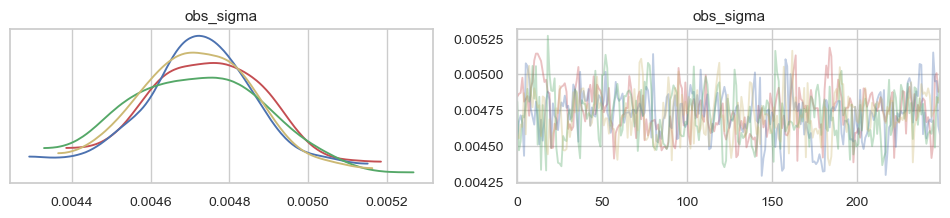

In [103]:
az.plot_trace(params, chain_prop={'color':['r','b','g','y']}, var_names = 'obs_sigma');

In [104]:
q = '''
SELECT toStartOfHour(time) hour_time,
       uniqExact(post_id) num_posts
FROM simulator_20250820.feed_actions
WHERE time >= toDateTime('2025-07-26 00:00:00')
  AND time <  toDateTime('2025-08-23 00:00:00')
GROUP BY hour_time
ORDER BY hour_time
'''

In [105]:
posts = client.query_df(q)

In [106]:
posts.head()

,hour_time,num_posts
0,2025-07-26 00:00:00+03:00,140
1,2025-07-26 01:00:00+03:00,140
2,2025-07-26 02:00:00+03:00,137
3,2025-07-26 03:00:00+03:00,137
4,2025-07-26 04:00:00+03:00,132


In [109]:
posts['hour_time'] = pd.to_datetime(posts['hour_time']).dt.tz_localize(None)

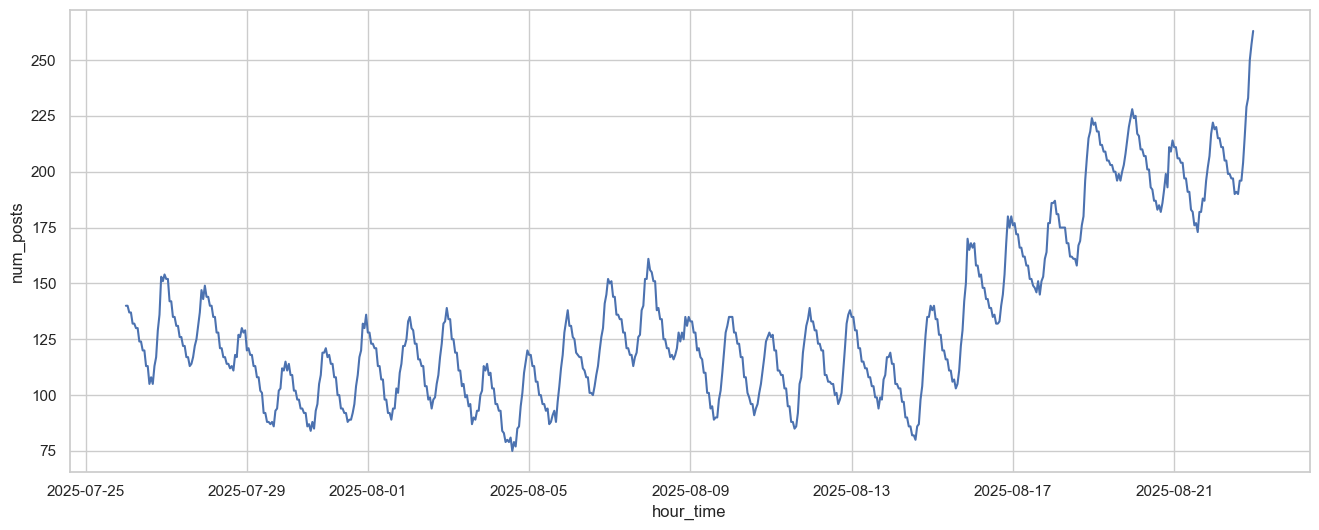

In [110]:
sns.lineplot(x='hour_time', y='num_posts', data=posts);

In [111]:
data_reg = activity.merge(posts)

In [112]:
data_reg

,hour_time,CTR,num_posts
0,2025-07-26 00:00:00,0.220720,140
1,2025-07-26 01:00:00,0.217071,140
2,2025-07-26 02:00:00,0.221075,137
3,2025-07-26 03:00:00,0.216127,137
4,2025-07-26 04:00:00,0.217627,132
...,...,...,...
667,2025-08-22 19:00:00,0.209487,229
668,2025-08-22 20:00:00,0.209446,233
669,2025-08-22 21:00:00,0.206052,250
670,2025-08-22 22:00:00,0.205755,257


In [113]:
data_reg.drop('hour_time', axis=1).corr()

,CTR,num_posts
CTR,1.000000,0.131309
num_posts,0.131309,1.000000


In [115]:
data_reg.drop('hour_time', axis=1).corr(method='spearman')

,CTR,num_posts
CTR,1.00000,0.10513
num_posts,0.10513,1.00000


In [122]:
q = '''
SELECT *
FROM simulator_20250820.feed_actions
LIMIT 100000
'''

In [123]:
df = client.query_df(q)

In [124]:
df

,user_id,post_id,action,time,gender,age,country,city,os,source,exp_group
0,106791,76,view,2025-07-06 00:26:19+03:00,0,45,Russia,Chelyabinsk,iOS,ads,3
1,659,76,view,2025-07-06 00:26:31+03:00,0,30,Russia,Partizansk,Android,ads,0
2,106791,76,like,2025-07-06 00:27:59+03:00,0,45,Russia,Chelyabinsk,iOS,ads,3
3,695,76,view,2025-07-06 00:29:39+03:00,1,27,Russia,Engels,Android,ads,0
4,695,76,like,2025-07-06 00:29:51+03:00,1,27,Russia,Engels,Android,ads,0
...,...,...,...,...,...,...,...,...,...,...,...
99995,157171,3785,like,2025-08-27 10:09:47+03:00,1,40,Russia,Izhevsk,Android,organic,4
99996,158417,3864,view,2025-08-27 10:09:47+03:00,0,19,Ukraine,Simferopol,iOS,organic,2
99997,158506,3874,view,2025-08-27 10:09:47+03:00,0,30,Ukraine,Odesa,iOS,organic,0
99998,158585,3729,view,2025-08-27 10:09:47+03:00,1,15,Russia,Khabarovsk,Android,organic,2


In [2]:
%pip install causalimpact pycausalimpact

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.5/535.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.1 MB/s eta 0:00:00
  Created wheel for logical-unification: filename=logical_unification-0.4.6-py3-none-any.whl size=13972 sha256=4fe6020406468514573c8ad39d9751e60e491585f67d00a841e2b9e0a1b8d90a
  Stored in directory: /Users/aleksey/Library/Caches/pip/wheels/4b/07/cf/3fdaedafc40d7b1861c98be0df1bf3b2b3e87e03187fa95298
Successfully built logical-unification


Note: you may need to restart the kernel to use updated packages.


In [6]:
# %pip install causalimpact pycausalimpact --quiet

import pandas as pd
import numpy as np
import clickhouse_connect

# --- 0) Параметры окна и даты вмешательства (post-период) ---
START = '2025-07-26'
END   = '2025-08-22'   # включительно
INTV  = '2025-08-15'   # дата вмешательства (пост-период начинается с неё)

# --- 1) Данные из ClickHouse: дневные метрики ---
client = clickhouse_connect.get_client(
    host='clickhouse.lab.karpov.courses',
    port=443, username='student', password='dpo_python_2020',
    database='simulator', secure=True
)

q = f"""
WITH daily AS (
  SELECT
    toDate(time) AS day,
    countDistinct(user_id)                                  AS dau,
    sum(action='view')                                      AS views,
    sum(action='like')                                      AS likes,
    countDistinctIf(post_id, action='view')                 AS uniq_posts_viewed
  FROM simulator_20250820.feed_actions
  WHERE time >= toDateTime('{START} 00:00:00')
    AND time <  toDateTime('{END} 23:59:59')
  GROUP BY day
),
new_posts AS (
  SELECT first_day AS day, count() AS new_posts
  FROM (
    SELECT post_id, min(toDate(time)) AS first_day
    FROM simulator_20250820.feed_actions
    GROUP BY post_id
  )
  WHERE first_day BETWEEN toDate('{START}') AND toDate('{END}')
  GROUP BY day
)
SELECT
  d.day,
  d.dau,
  d.views,
  d.likes,
  d.uniq_posts_viewed,
  coalesce(np.new_posts, 0) AS new_posts
FROM daily d
LEFT JOIN new_posts np USING (day)
ORDER BY d.day
"""
df = client.query_df(q)

# --- 2) Приводим к полной ежедневной сетке и считаем CTR ---
idx = pd.date_range(df['day'].min(), df['day'].max(), freq='D')
df  = df.set_index('day').reindex(idx).rename_axis('day').reset_index()
for col in ['dau','views','likes','uniq_posts_viewed','new_posts']:
    df[col] = df[col].fillna(0).astype(float)

# CTR как likes/views; безопасное деление
df['ctr'] = np.where(df['views'] > 0, df['likes'] / df['views'], np.nan)
df['ctr'] = df['ctr'].ffill().fillna(0.0)

# --- 3) CausalImpact (без ковариат; базовая постановка) ---
try:
    from causalimpact import CausalImpact
except Exception:
    from pycausalimpact import CausalImpact  # fallback

def run_impact(series: pd.Series, pre_start: str, pre_end: str, post_start: str, post_end: str):
    ts = pd.DataFrame({'y': series.values}, index=pd.to_datetime(df['day']))
    impact = CausalImpact(ts, [pre_start, pre_end], [post_start, post_end])

    # p-value, если есть
    p = float(getattr(impact, 'p_value', np.nan))

    avg_eff = None

    # 1) Пытаемся вытащить из summary_data (pycausalimpact)
    sd = getattr(impact, 'summary_data', None)
    if isinstance(sd, pd.DataFrame) and not sd.empty and 'average' in sd.index:
        for col in ('point_effect', 'point.effect', 'AbsEffect', 'abs_effect'):
            if col in sd.columns:
                avg_eff = float(sd.loc['average', col])
                break

    # 2) Либо из inferences (python-causalimpact)
    if avg_eff is None:
        inf = getattr(impact, 'inferences', None)
        if isinstance(inf, pd.DataFrame) and not inf.empty:
            eff_col = next((c for c in ('point_effect','point.effect','AbsEffect','abs_effect') if c in inf.columns), None)
            if eff_col:
                post_mask = (inf.index >= pd.to_datetime(post_start)) & (inf.index <= pd.to_datetime(post_end))
                avg_eff = float(inf.loc[post_mask, eff_col].mean())

    # 3) Последний резерв: разница средних пост-периода и пре-периода
    if avg_eff is None:
        post_mask = (ts.index >= pd.to_datetime(post_start)) & (ts.index <= pd.to_datetime(post_end))
        avg_eff = float(ts.loc[post_mask, 'y'].mean() - ts.loc[~post_mask, 'y'].mean())

    return p, avg_eff

pre_start, pre_end = START, (pd.to_datetime(INTV) - pd.Timedelta(days=1)).strftime('%Y-%m-%d')
post_start, post_end = INTV, END

results = {}

# DAU
p, eff = run_impact(df['dau'], pre_start, pre_end, post_start, post_end)
results['DAU'] = dict(p=p, eff=eff)

# CTR
p, eff = run_impact(df['ctr'], pre_start, pre_end, post_start, post_end)
results['CTR'] = dict(p=p, eff=eff)

# Views
p, eff = run_impact(df['views'], pre_start, pre_end, post_start, post_end)
results['Views'] = dict(p=p, eff=eff)

# New posts
p, eff = run_impact(df['new_posts'], pre_start, pre_end, post_start, post_end)
results['NewPosts'] = dict(p=p, eff=eff)

# Unique viewed posts
p, eff = run_impact(df['uniq_posts_viewed'], pre_start, pre_end, post_start, post_end)
results['UniquePosts'] = dict(p=p, eff=eff)

# --- 4) Мэппинг на варианты ответа (берём ближайшее из предложенных чисел) ---
choices = {
    'DAU':                   [-9645, -1380, 850, 3150],
    'CTR':                   [-0.03, -0.01, 0.0, 0.01],
    'Views':                 [-761873, -562914, 659855, 4618988],
    'NewPosts':              [-17, -2, 8, 11],
    'UniquePosts':           [-94, -58, 76, 534],
}
def nearest(x, pool): return min(pool, key=lambda v: abs(x - v))

def verdict(p, eff, metric):
    # текст для формы
    if metric == 'CTR':
        if p >= 0.05:
            txt = 'значимо не изменился'
        else:
            if abs(eff) < 0.01:
                txt = 'значимо, но незначительно вырос' if eff > 0 else 'значимо, но незначительно упал'
            else:
                txt = 'значимо вырос' if eff > 0 else 'значимо упал'
    else:
        if p >= 0.05:
            txt = 'значимо не изменилось'
        else:
            txt = 'значимо выросло' if eff > 0 else 'значимо упало'
    return txt

filled = {
    'DAU': (
        verdict(results['DAU']['p'], results['DAU']['eff'], 'DAU'),
        nearest(results['DAU']['eff'], choices['DAU']),
    ),
    'CTR': (
        verdict(results['CTR']['p'], results['CTR']['eff'], 'CTR'),
        nearest(results['CTR']['eff'], choices['CTR']),
    ),
    'Views': (
        verdict(results['Views']['p'], results['Views']['eff'], 'Views'),
        nearest(results['Views']['eff'], choices['Views']),
    ),
    'NewPosts': (
        verdict(results['NewPosts']['p'], results['NewPosts']['eff'], 'NewPosts'),
        nearest(results['NewPosts']['eff'], choices['NewPosts']),
    ),
    'UniquePosts': (
        verdict(results['UniquePosts']['p'], results['UniquePosts']['eff'], 'UniquePosts'),
        nearest(results['UniquePosts']['eff'], choices['UniquePosts']),
    ),
}

# --- 5) Печать в нужном формате ---
print(f"DAU {filled['DAU'][0]}. Средняя величина абсолютного эффекта - примерно {filled['DAU'][1]}.")
print(f"CTR {filled['CTR'][0]}. Средняя величина абсолютного эффекта - примерно {filled['CTR'][1]}.")
print(f"Число просмотров {filled['Views'][0]}. Средняя величина абсолютного эффекта - примерно {filled['Views'][1]}.")
print(f"Число новых постов {filled['NewPosts'][0]}. Средняя величина абсолютного эффекта - примерно {filled['NewPosts'][1]}.")
print(f"Число уникальных просматриваемых постов {filled['UniquePosts'][0]}. Средняя величина абсолютного эффекта - примерно {filled['UniquePosts'][1]}.")

DAU значимо выросло. Средняя величина абсолютного эффекта - примерно 3150.
CTR значимо, но незначительно вырос. Средняя величина абсолютного эффекта - примерно 0.0.
Число просмотров значимо выросло. Средняя величина абсолютного эффекта - примерно 659855.
Число новых постов значимо выросло. Средняя величина абсолютного эффекта - примерно 11.
Число уникальных просматриваемых постов значимо выросло. Средняя величина абсолютного эффекта - примерно 76.


In [7]:
print(f"CTR avg effect (raw) = {results['CTR']['eff']:.6f}, p={results['CTR']['p']:.4f}")

CTR avg effect (raw) = 0.001519, p=nan
